# Shane's Swing Trading Strategy

* Stocks have support levels
    * e.g. MSFT hits recent low of $400 on May 1st, then hits a similar low of $390 on Aug 5th
    * Stocks reaching support levels is a buying opportunity
* However, good stocks trend up
    * This means the support level of good stocks rise over time
    * Thus it's difficult to rely on historical price data to determine support levels
* To adjust for this, we calculate support levels not by historical price but rather historical difference between price and 200 SMA
    * 200 SMA is a good indicator for the general direction of a stock
    * The difference between the price and the 200 SMA then measures the residual of the price from its expected price

In [451]:
import alpaca_trade_api as alpaca
from alpaca.trading.client import TradingClient
from alpaca.trading.requests import MarketOrderRequest
from alpaca.trading.enums import OrderSide, TimeInForce
from dotenv import load_dotenv
import os
import pandas as pd
import talib as ta
import matplotlib.pyplot as plt
import time
import datetime as dt

In [452]:
# initialize API from API keys in .env
load_dotenv()
api_key = os.environ['APCA-API-KEY-ID']
api_secret_key = os.environ['APCA-API-SECRET-KEY']
api_base_url = 'https://paper-api.alpaca.markets'
api = alpaca.REST(api_key, api_secret_key, api_base_url)
account = api.get_account()
trading_client = TradingClient(api_key, api_secret_key, paper=True)

In [453]:
def market_buy_order(ticker, quantity):
    time.sleep(0.2)
    market_order_data = MarketOrderRequest(
                        symbol=ticker,
                        qty=quantity,
                        side=OrderSide.BUY,
                        time_in_force=TimeInForce.DAY
                        )
    market_order = trading_client.submit_order(order_data=market_order_data)
    print(market_order)
    
def market_sell_order(ticker, quantity):
    time.sleep(0.2)
    market_order_data = MarketOrderRequest(
                        symbol=ticker,
                        qty=quantity,
                        side=OrderSide.SELL,
                        time_in_force=TimeInForce.DAY
                        )
    market_order = trading_client.submit_order(order_data=market_order_data)
    print(market_order)

In [454]:
def get_SP500():
    return pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

def add_business_days(start_date: dt.date, n: int) -> dt.date:
    weeks, extra_days = divmod(n, 5)
    result_date = start_date + dt.timedelta(weeks=weeks)

    if extra_days != 0:
        start_weekday = result_date.weekday()
        
        if start_weekday + extra_days > 4:
            extra_days += 2
        result_date += dt.timedelta(days=extra_days)
    return result_date

def bars_last_n_days(ticker, days):
    now = dt.datetime.now(dt.timezone.utc)
    todays_date = now.strftime("%Y-%m-%d")
    start_date = (now - dt.timedelta(days=days)).strftime("%Y-%m-%d")
    fh_date_time = start_date + "T14:30:00Z"
    bars = api.get_bars(ticker, alpaca.TimeFrame.Day, fh_date_time, adjustment='split').df
    return bars

def bars_last_n_weeks(ticker, weeks):
    now = dt.datetime.now(dt.timezone.utc)
    todays_date = now.strftime("%Y-%m-%d")
    start_date = (now - dt.timedelta(weeks=weeks)).strftime("%Y-%m-%d")
    fh_date_time = start_date + "T14:30:00Z"
    bars = api.get_bars(ticker, alpaca.TimeFrame.Day, fh_date_time, adjustment='split').df
    bars = bars.reset_index()
    bars = bars.rename(columns={'timestamp': 'date'})
    bars['date'] = pd.to_datetime(bars['date']).dt.date
    bars = bars.set_index('date')
    return bars

def add_SMA(bars, days):
    bars[f"{days} day SMA"] = ta.SMA(bars['close'], timeperiod=days)
    bars[f"close - {days} day SMA"] = bars['close'] - bars[f"{days} day SMA"]
    return bars[bars[f"{days} day SMA"].notna()]

def SMA_slope(bars, sma_days):
    time_period = 5
    return (bars.iloc[-1][f"{sma_days} day SMA"] - bars.iloc[-1 - time_period][f"{sma_days} day SMA"]) / time_period

def get_troughs(bars, n_troughs, radius):
    trough_dates = []
    sorted_bars = bars.sort_values('close - 200 day SMA')
    for i in range(len(sorted_bars)):
        close_prox = False
        row = sorted_bars.iloc[i]
        date = row.name
        for tdate in trough_dates:
            lower_bound = add_business_days(tdate, -radius)
            upper_bound = add_business_days(tdate, radius)
            if date >= lower_bound and date <= upper_bound:
                close_prox = True
                break
        if close_prox:
            continue
        trough_dates.append(date)
        if len(trough_dates) >= n_troughs:
            break
    return sorted_bars[sorted_bars.index.isin(trough_dates)].sort_index()

In [ ]:
def execute_trading_strategy():
    troughs_std_threshold = 0.025
    SMA_slope_yearly_threshold = 0.20
    buy_amount = 5000

    held_tickers = []
    all_positions = trading_client.get_all_positions()
    for position in all_positions:
        held_tickers.append(position.symbol)
    held_tickers

    SP500 = get_SP500()
    # tickers = pd.read_csv('trading_tickers.csv')
    for ticker in SP500['Symbol']:
        if ticker in held_tickers:
            continue
        time.sleep(0.05)
        bars = bars_last_n_weeks(ticker, 85)
        print(ticker)
        bars = add_SMA(bars, 200)
        if bars.empty:
            continue
        troughs = get_troughs(bars, 7, 5)
        # troughs_range = troughs['close - 200 day SMA'].max() - troughs['close - 200 day SMA'].min()
        troughs_std = troughs['close - 200 day SMA'].std()
        troughs_mean = troughs['close - 200 day SMA'].mean()
        latest_trade = api.get_latest_trade(ticker)
        current_price = latest_trade.p
        last_sma = bars.iloc[-1]['200 day SMA']
        SMA_200_slope_percentage = SMA_slope(bars, 200) / current_price
        
        if troughs_std / current_price > troughs_std_threshold:
            continue 
        if current_price - last_sma > troughs_mean:
            continue
        if SMA_200_slope_percentage * 365 < SMA_slope_yearly_threshold:
            continue
        shares_to_buy = buy_amount / current_price
        market_buy_order(ticker, shares_to_buy)
        print(f"bought {ticker}")

    sell_threshold = 0.03

    for position in all_positions:
        avg_cost_basis = float(position.avg_entry_price)
        current_price = float(position.current_price)
        if current_price > avg_cost_basis * (1 + sell_threshold) or current_price < avg_cost_basis * (1 - sell_threshold):
            market_sell_order(position.qty)
            print(f"sold {position.symbol}")

In [456]:
execute_trading_strategy()



MMM
AOS
ABT
ABBV
ACN
ADBE
AMD
AES
AFL
A
APD
ABNB
AKAM
ALB
ARE
ALGN
ALLE
LNT
ALL
GOOGL
GOOG
MO
AMZN
AMCR
AMTM
AEE
AEP
AXP
AIG
AMT
AWK
AMP
AME
AMGN
APH
ADI
ANSS
AON
APA
AAPL
AMAT
APTV
ACGL
ADM
ANET
AJG
AIZ
T
ATO
ADSK
ADP
AZO
AVB
AVY
AXON
BKR
BALL
BAC
BAX
BDX
BRK.B
BBY
TECH
BIIB
BLK
BX
BK
BA


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/BKNG/bars 3 more time(s)...


BKNG
BWA
BSX
BMY
AVGO
BR


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/BRO/bars 3 more time(s)...


BRO
BF.B
BLDR
BG
BXP
CHRW


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/CDNS/trades/latest 3 more time(s)...


CDNS
CZR
CPT
CPB
COF
CAH


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/CCL/bars 3 more time(s)...


KMX
CCL
CARR
CTLT
CAT
CBOE


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/CBRE/trades/latest 3 more time(s)...


CBRE
CDW
CE
COR
CNC
CNP


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/CRL/bars 3 more time(s)...


CF
CRL
SCHW
CHTR
CVX
CMG
CB


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/CB/trades/latest 3 more time(s)...


id=UUID('21afaf71-7e03-40f0-a942-2a25108f42a8') client_order_id='05bf26d0-2331-416e-91c1-d5f6fda86e44' created_at=datetime.datetime(2024, 11, 20, 19, 31, 50, 57132, tzinfo=TzInfo(UTC)) updated_at=datetime.datetime(2024, 11, 20, 19, 31, 50, 57795, tzinfo=TzInfo(UTC)) submitted_at=datetime.datetime(2024, 11, 20, 19, 31, 50, 57132, tzinfo=TzInfo(UTC)) filled_at=None expired_at=None canceled_at=None failed_at=None replaced_at=None replaced_by=None replaces=None asset_id=UUID('2453845c-4785-46de-b332-6ee2438da196') symbol='CB' asset_class=<AssetClass.US_EQUITY: 'us_equity'> notional=None qty='10.667045939' filled_qty='0' filled_avg_price=None order_class=<OrderClass.SIMPLE: 'simple'> order_type=<OrderType.MARKET: 'market'> type=<OrderType.MARKET: 'market'> side=<OrderSide.BUY: 'buy'> time_in_force=<TimeInForce.DAY: 'day'> limit_price=None stop_price=None status=<OrderStatus.PENDING_NEW: 'pending_new'> extended_hours=False legs=None trail_percent=None trail_price=None hwm=None
bought CB
CHD


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/CFG/bars 3 more time(s)...


C
CFG
CLX
CME
CMS
KO
CTSH


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/CL/bars 3 more time(s)...


CL
CMCSA
CAG
COP
ED


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/CEG/trades/latest 3 more time(s)...


STZ
CEG
COO
CPRT
GLW
CPAY
CTVA


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/COST/bars 3 more time(s)...


CSGP
COST
CTRA
CRWD
CCI
CSX
CMI


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/CVS/trades/latest 3 more time(s)...


CVS
DHR
DRI
DVA
DAY


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/DE/trades/latest 3 more time(s)...


DECK
DE
DELL
DAL
DVN
DXCM


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/DLR/trades/latest 3 more time(s)...


FANG
DLR
DFS
DG
DLTR
D


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/DOW/bars 3 more time(s)...


DPZ
DOV
DOW
DHI
DTE
DUK
DD


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/ETN/trades/latest 3 more time(s)...


EMN
ETN
EBAY
ECL
id=UUID('ceabbd35-5d25-4872-8a71-d0a5ccf58185') client_order_id='9c64ea01-dae8-4bca-b528-9e8d0eaab893' created_at=datetime.datetime(2024, 11, 20, 19, 32, 24, 147307, tzinfo=TzInfo(UTC)) updated_at=datetime.datetime(2024, 11, 20, 19, 32, 24, 148278, tzinfo=TzInfo(UTC)) submitted_at=datetime.datetime(2024, 11, 20, 19, 32, 24, 147307, tzinfo=TzInfo(UTC)) filled_at=None expired_at=None canceled_at=None failed_at=None replaced_at=None replaced_by=None replaces=None asset_id=UUID('b636b9b8-669c-4788-a0eb-ff5f6ea7f09e') symbol='ECL' asset_class=<AssetClass.US_EQUITY: 'us_equity'> notional=None qty='12.45847176' filled_qty='0' filled_avg_price=None order_class=<OrderClass.SIMPLE: 'simple'> order_type=<OrderType.MARKET: 'market'> type=<OrderType.MARKET: 'market'> side=<OrderSide.BUY: 'buy'> time_in_force=<TimeInForce.DAY: 'day'> limit_price=None stop_price=None status=<OrderStatus.PENDING_NEW: 'pending_new'> extended_hours=False legs=None trail_percent=None trail_price=None hwm

sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/EMR/bars 3 more time(s)...


EMR
ENPH
ETR
EOG
EPAM


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/EQT/trades/latest 3 more time(s)...


EQT
EFX
EQIX
EQR
ERIE
ESS
EL


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/EG/trades/latest 3 more time(s)...


EG
EVRG
ES
EXC
EXPE
EXPD
EXR
XOM


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/FFIV/bars 3 more time(s)...


FFIV
FDS
FICO
FAST
FRT
FDX


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/FIS/trades/latest 3 more time(s)...


FIS
FITB
FSLR
FE


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/F/bars 3 more time(s)...


FI
FMC
F
FTNT
FTV
FOXA
FOX
BEN


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/FCX/trades/latest 3 more time(s)...


FCX
GRMN
IT
GE
id=UUID('b7604148-82c7-4c57-b453-972ee56ab053') client_order_id='af2b2859-b347-4fcd-ac64-c7587b11c573' created_at=datetime.datetime(2024, 11, 20, 19, 32, 51, 556466, tzinfo=TzInfo(UTC)) updated_at=datetime.datetime(2024, 11, 20, 19, 32, 51, 557440, tzinfo=TzInfo(UTC)) submitted_at=datetime.datetime(2024, 11, 20, 19, 32, 51, 556466, tzinfo=TzInfo(UTC)) filled_at=None expired_at=None canceled_at=None failed_at=None replaced_at=None replaced_by=None replaces=None asset_id=UUID('0116ac5c-90bc-47a2-8bb4-0f4551521dc6') symbol='GE' asset_class=<AssetClass.US_EQUITY: 'us_equity'> notional=None qty='16.946280291' filled_qty='0' filled_avg_price=None order_class=<OrderClass.SIMPLE: 'simple'> order_type=<OrderType.MARKET: 'market'> type=<OrderType.MARKET: 'market'> side=<OrderSide.BUY: 'buy'> time_in_force=<TimeInForce.DAY: 'day'> limit_price=None stop_price=None status=<OrderStatus.PENDING_NEW: 'pending_new'> extended_hours=False legs=None trail_percent=None trail_price=None hwm=N

sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/GD/bars 3 more time(s)...


GEN
GNRC
GD
GIS
GM
GPC
GILD
GPN


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/GL/trades/latest 3 more time(s)...


GL
GDDY
GS
HAL
HIG
HAS


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/HCA/trades/latest 3 more time(s)...


HCA
DOC
HSIC
HSY
HES
HPE


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/HOLX/bars 3 more time(s)...


HLT
HOLX
HD
HON
HRL
HST
HWM


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/HPQ/trades/latest 3 more time(s)...


HPQ
HUBB
HUM
HBAN
HII
IBM


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/IDXX/bars 3 more time(s)...


IEX
IDXX
ITW
INCY
IR
PODD
INTC


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/ICE/bars 3 more time(s)...


ICE
IFF
IP
IPG
INTU
ISRG


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/IVZ/trades/latest 3 more time(s)...


IVZ
INVH
IQV
IRM
JBHT
JBL
JKHY


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/J/bars 3 more time(s)...


J
JNJ
JCI
JPM
JNPR
K


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/KVUE/bars 3 more time(s)...


KVUE
KDP
KEY
KEYS
KMB
KIM


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/KMI/trades/latest 3 more time(s)...


KMI
KKR
KLAC
KHC
KR


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/LH/trades/latest 3 more time(s)...


LHX
LH
LRCX
LW
LVS
LDOS
id=UUID('86307698-a719-499c-a29b-3c4be9445301') client_order_id='9b8b7891-664b-4a77-8fcd-38d309c18ceb' created_at=datetime.datetime(2024, 11, 20, 19, 33, 37, 540629, tzinfo=TzInfo(UTC)) updated_at=datetime.datetime(2024, 11, 20, 19, 33, 37, 541581, tzinfo=TzInfo(UTC)) submitted_at=datetime.datetime(2024, 11, 20, 19, 33, 37, 540629, tzinfo=TzInfo(UTC)) filled_at=None expired_at=None canceled_at=None failed_at=None replaced_at=None replaced_by=None replaces=None asset_id=UUID('0baeabb2-12ac-4751-af09-fcb671f498a7') symbol='LDOS' asset_class=<AssetClass.US_EQUITY: 'us_equity'> notional=None qty='18.70207593' filled_qty='0' filled_avg_price=None order_class=<OrderClass.SIMPLE: 'simple'> order_type=<OrderType.MARKET: 'market'> type=<OrderType.MARKET: 'market'> side=<OrderSide.BUY: 'buy'> time_in_force=<TimeInForce.DAY: 'day'> limit_price=None stop_price=None status=<OrderStatus.PENDING_NEW: 'pending_new'> extended_hours=False legs=None trail_percent=None trail_price=

sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/LIN/bars 3 more time(s)...


LIN
LYV
LKQ
LMT
L
LOW
LULU


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/LULU/trades/latest 3 more time(s)...


LYB
MTB
MRO
MPC
MKTX
MAR


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/MMC/trades/latest 3 more time(s)...


MMC
MLM
MAS
MA
MTCH


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/MCK/bars 3 more time(s)...


MKC
MCD
MCK
MDT
MRK
META
MET
MTD


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/MGM/trades/latest 3 more time(s)...


MGM
MCHP
MU
MSFT
MAA


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/MOH/bars 3 more time(s)...


MRNA
MHK
MOH
TAP
MDLZ
MPWR
MNST


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/MCO/trades/latest 3 more time(s)...


MCO
MS
MOS
MSI
MSCI
NDAQ


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/NFLX/bars 3 more time(s)...


NTAP
NFLX
NEM
NWSA
NWS
NEE
NKE


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/NDSN/bars 3 more time(s)...


NI
NDSN
NSC
NTRS
NOC
NCLH
NRG


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/NVDA/trades/latest 3 more time(s)...


NUE
NVDA
NVR
NXPI
ORLY
OXY


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/OMC/trades/latest 3 more time(s)...


ODFL
OMC
ON
OKE
ORCL
OTIS
PCAR
PKG


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/PLTR/bars 3 more time(s)...


PLTR
PANW
PARA
PH


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/PYPL/bars 3 more time(s)...


PAYX
PAYC
PYPL
PNR
PEP
PFE
PCG
PM


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/PSX/trades/latest 3 more time(s)...


PSX
PNW
PNC
POOL
PPG
PPL


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/PG/bars 3 more time(s)...


PFG
PG
PGR
PLD
PRU
PEG
PTC


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/PSA/bars 3 more time(s)...


PSA
PHM
QRVO
PWR
QCOM
DGX


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/RL/trades/latest 3 more time(s)...


RL
RJF
RTX
O
REG


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/RF/trades/latest 3 more time(s)...


REGN
RF
RSG
RMD
RVTY
ROK
ROL
ROP


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/ROST/bars 3 more time(s)...


ROST
RCL
SPGI
CRM
SBAC
SLB


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/SLB/trades/latest 3 more time(s)...


STX
SRE
NOW
SHW
SPG
SWKS


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/SW/bars 3 more time(s)...


SJM
SW
SNA
SOLV
SO
LUV
SWK


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/SBUX/trades/latest 3 more time(s)...


SBUX
STT
STLD
STE
SYK
SMCI


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/SYF/trades/latest 3 more time(s)...


SYF
SNPS
SYY
TMUS
TROW
TTWO


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/TRGP/bars 3 more time(s)...


TPR
TRGP
TGT
TEL
TDY


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/TER/trades/latest 3 more time(s)...


TFX
TER
TSLA
TXN
TXT
TMO
TJX
TSCO


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/TDG/bars 3 more time(s)...


id=UUID('73cf9eca-5364-4300-afe2-65168bd56289') client_order_id='96ba2fe8-f287-4a3a-a130-0e302f5b5d86' created_at=datetime.datetime(2024, 11, 20, 19, 35, 13, 819260, tzinfo=TzInfo(UTC)) updated_at=datetime.datetime(2024, 11, 20, 19, 35, 13, 820081, tzinfo=TzInfo(UTC)) submitted_at=datetime.datetime(2024, 11, 20, 19, 35, 13, 819260, tzinfo=TzInfo(UTC)) filled_at=None expired_at=None canceled_at=None failed_at=None replaced_at=None replaced_by=None replaces=None asset_id=UUID('6c288372-d98d-496a-b32f-56b65e485246') symbol='TSCO' asset_class=<AssetClass.US_EQUITY: 'us_equity'> notional=None qty='11.172768239' filled_qty='0' filled_avg_price=None order_class=<OrderClass.SIMPLE: 'simple'> order_type=<OrderType.MARKET: 'market'> type=<OrderType.MARKET: 'market'> side=<OrderSide.BUY: 'buy'> time_in_force=<TimeInForce.DAY: 'day'> limit_price=None stop_price=None status=<OrderStatus.PENDING_NEW: 'pending_new'> extended_hours=False legs=None trail_percent=None trail_price=None hwm=None
bought TS

sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/USB/trades/latest 3 more time(s)...


UBER
UDR
ULTA
UNP
UAL
UPS


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/URI/bars 3 more time(s)...


URI
UNH
UHS
VLO


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/VLTO/trades/latest 3 more time(s)...


VTR
VLTO
VRSN
VRSK
VZ
VRTX
VTRS


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/V/trades/latest 3 more time(s)...


VICI
V
VST
VMC
WRB
GWW
WAB


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/WMT/trades/latest 3 more time(s)...


WBA
WMT
DIS
WBD
WM
WAT
WEC


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/WELL/bars 3 more time(s)...


WFC
WELL
WST
WDC
WY
WMB
WTW


sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/WYNN/trades/latest 3 more time(s)...


WYNN
XEL
XYL
YUM
ZBRA
ZBH
ZTS


In [457]:
ticker = 'KO'
bars = bars_last_n_weeks(ticker, 85)
bars = add_SMA(bars, 200)
print(SMA_slope(bars, 200))
display(bars)
bars.sort_values('close - 200 day SMA').head(20)

sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/KO/bars 3 more time(s)...


0.010649999999998272


,close,high,low,trade_count,open,volume,vwap,200 day SMA,close - 200 day SMA
date,,,,,,,,,
2024-01-23,59.85,60.00,59.460,115208,59.53,14481643,59.808040,59.62930,0.22070
2024-01-24,58.91,59.81,58.890,134332,59.80,16370484,59.241983,59.60965,-0.69965
2024-01-25,59.16,59.17,58.660,128352,59.01,14899712,58.988842,59.59200,-0.43200
2024-01-26,59.37,59.49,59.125,109480,59.25,13025072,59.334764,59.57595,-0.20595
2024-01-29,59.73,59.79,59.170,114989,59.34,14547070,59.517974,59.56115,0.16885
...,...,...,...,...,...,...,...,...,...
2024-11-14,62.55,63.11,62.430,153715,63.11,15910820,62.680813,64.57985,-2.02985
2024-11-15,61.74,62.63,61.390,216302,62.49,26204290,61.746808,64.58365,-2.84365
2024-11-18,61.86,62.14,61.560,137407,61.85,16079364,61.890968,64.59025,-2.73025


,close,high,low,trade_count,open,volume,vwap,200 day SMA,close - 200 day SMA
date,,,,,,,,,
2024-11-15,61.74,62.630,61.3900,216302,62.49,26204290,61.746808,64.58365,-2.84365
2024-11-18,61.86,62.140,61.5600,137407,61.85,16079364,61.890968,64.59025,-2.73025
2024-11-14,62.55,63.110,62.4300,153715,63.11,15910820,62.680813,64.57985,-2.02985
2024-11-19,62.59,62.620,61.6300,142412,61.90,16250116,62.268566,64.60300,-2.01300
2024-11-20,62.90,62.910,62.0200,99478,62.70,7431902,62.510931,64.61780,-1.71780
2024-11-13,63.00,63.260,62.4900,129589,63.05,13177637,62.958579,64.56455,-1.56455
2024-11-12,63.20,63.750,63.1200,144222,63.68,15020975,63.348218,64.54905,-1.34905
2024-11-11,63.36,64.120,63.2509,158956,63.99,13980873,63.595594,64.53170,-1.17170
2024-04-16,58.06,58.380,57.9300,128291,58.25,11236839,58.133096,58.96215,-0.90215


In [458]:
print(SMA_slope(bars, 200))
slope = SMA_slope(bars, 200)
latest_trade = api.get_latest_trade(ticker)
current_price = latest_trade.p
print(slope / current_price)
print(slope / current_price * 365)

0.010649999999998272
0.0001693029170971826
0.06179556474047165


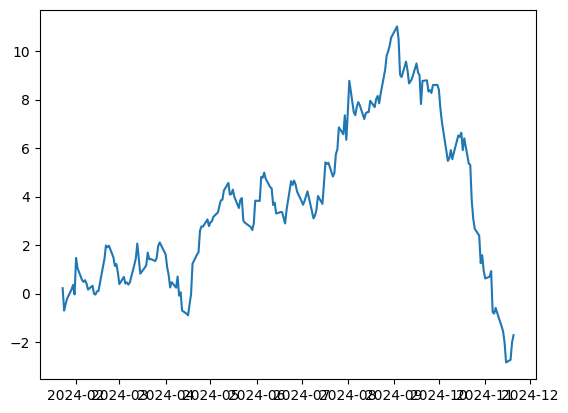

<Figure size 640x480 with 0 Axes>

In [459]:
plt.plot(bars['close - 200 day SMA'])
plt.show()
plt.clf()

In [460]:
troughs = get_troughs(bars, 7, 5)
troughs_range = troughs['close - 200 day SMA'].max() - troughs['close - 200 day SMA'].min()
troughs_std = troughs['close - 200 day SMA'].std()
troughs_mean = troughs['close - 200 day SMA'].mean()
print(troughs_range)
print(troughs_std)
print(troughs_mean)
print(bars.iloc[-1]['200 day SMA'])
troughs

3.210000000000022
1.087601615449604
-0.6730857142857373
64.61780000000003


,close,high,low,trade_count,open,volume,vwap,200 day SMA,close - 200 day SMA
date,,,,,,,,,
2024-01-24,58.91,59.81,58.890,134332,59.80,16370484,59.241983,59.60965,-0.69965
2024-02-14,59.29,59.59,59.035,147078,59.17,15872453,59.258362,59.33375,-0.04375
2024-03-07,59.44,59.77,59.240,120821,59.69,13686859,59.415334,59.07365,0.36635
2024-04-08,59.27,59.47,59.070,126002,59.40,10284535,59.266136,59.03080,0.23920
2024-04-16,58.06,58.38,57.930,128291,58.25,11236839,58.133096,58.96215,-0.90215
2024-11-07,63.66,64.39,63.600,195427,64.29,14856051,63.816896,64.48795,-0.82795
2024-11-15,61.74,62.63,61.390,216302,62.49,26204290,61.746808,64.58365,-2.84365
